## Vector-valued function with Random Fourier Features

### Imports

In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

### Values

In [2]:
dimension = 2
sigma = 10
sigma2 = 2*sigma**2

# Random Fourier features
m = 20 # number of samples
w = np.array([randn(m) / sigma, randn(m) / sigma]) # w is the same size as the dimensions times the number of samples
b = np.random.rand(m)*2*np.pi # b is the same size as number of samples

n = 500 # number of points

x1 = randn(n)/2
x2 =  randn(n)/2
x_vector = np.array([x1, x2])
# x_vector = np.block([x1,x2])

noise = randn(n) * 1e-1
#y1 = np.cos(x1) + noise
#y2 = np.sin(x2) + noise

y1 = 1+np.sin(x1/10) + x1**2 + noise
y2 = 0.5 * x2**2 + np.exp(x2) + noise

y = np.array(np.ravel([y1, y2], 'F'))

lam = 0.000001 # Regularization parameter
y.shape

(1000,)

### Gaussian Kernel

In [3]:
def k_gauss(x, z):
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def k_matrix(x, z, dim):
    k = k_gauss(x, z)
    k_matrix = k *np.eye(dim)
    return k_matrix

def K_gauss(x, n, dim):
    K = np.zeros((dim*n, dim*n))
    for i in range(0, n):
        for j in range(0, n):
            k = k_gauss(x[:,i], x[:,j])
            K[i*dim][j*dim] = k
            K[i*dim+1][j*dim+1] = k
    return K

K = K_gauss(x_vector, n, dimension)
K

array([[1.        , 0.        , 0.99591278, ..., 0.        , 0.99137484,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.99731623, 0.        ,
        0.99137484],
       [0.99591278, 0.        , 1.        , ..., 0.        , 0.99366601,
        0.        ],
       ...,
       [0.        , 0.99731623, 0.        , ..., 1.        , 0.        ,
        0.99829751],
       [0.99137484, 0.        , 0.99366601, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.99137484, 0.        , ..., 0.99829751, 0.        ,
        1.        ]])

#### Alpha

In [4]:
# Returns a vector with length dim * n
def alpha(x, y, lam, n, dim):
    K = K_gauss(x, n, dim)
    alpha_vector = np.linalg.inv((K + lam*np.eye(dim*n))) @ y
    alpha_reshape = [alpha_vector[::2], alpha_vector[1::2]]
    return np.array(alpha_reshape)

alpha_ = alpha(x_vector, y, lam, n, dimension)
alpha_

array([[-1.09233217e+05,  5.52580754e+04, -4.53073144e+04,
        -8.85549300e+04,  8.62920287e+04,  9.30968537e+04,
         7.55650982e+04, -5.00896231e+04,  2.06467949e+05,
        -2.59256896e+03,  4.89702897e+04, -1.30270661e+05,
        -2.18485318e+05, -8.58815919e+04, -2.34736054e+04,
        -2.07017895e+05, -5.74860021e+04,  1.46724760e+03,
         3.44149729e+04,  3.59356343e+04, -1.15332906e+05,
         1.49825638e+04,  6.41070264e+04, -1.01987503e+04,
         5.73819264e+04, -1.41752217e+03,  5.35376900e+04,
        -1.61012862e+05,  1.25714302e+05,  1.38396623e+05,
         2.23014689e+04, -5.68313818e+04,  9.69442444e+04,
         4.13986485e+04, -8.33798964e+04,  1.98489819e+05,
        -1.20040327e+05,  1.43017648e+05, -2.08332014e+05,
         1.14336681e+05,  3.50169050e+04, -4.97110996e+04,
        -6.90309864e+04, -1.23497175e+04,  2.29673241e+04,
        -1.36500704e+05,  2.39159155e+05, -7.68882356e+04,
         2.70577216e+05, -1.05894225e+05,  1.57607880e+0

#### Estimated function

In [5]:
def estimated_function(alpha, x, n, dim):
    function = np.zeros((2, n))
    for i in range(n):
        sum = np.zeros((2))
        x_i = x[:, i]
        for j in range(n):
            k = k_gauss(x_i, x[:, j])
            kernel = k*np.eye(dim)
            sum = sum + kernel@alpha[:, j]
        function[:, i] = sum 
    return function

func = estimated_function(alpha_, x_vector, n, dimension)
func

array([[1.01911032, 1.57340036, 1.40231704, 1.45696543, 0.99906608,
        1.17448376, 2.76864551, 1.02076982, 1.05018705, 1.06893064,
        1.04915848, 1.10791564, 1.06374367, 1.72348681, 1.35804201,
        1.41458505, 1.46549727, 1.02425258, 1.42011684, 1.52314658,
        1.03461513, 1.06299582, 1.26921249, 0.98668962, 1.00103978,
        1.0152385 , 1.65885334, 1.43525045, 1.12863675, 1.00455584,
        1.43889689, 1.03629497, 1.12655358, 0.99428468, 1.03600205,
        1.20232832, 1.0339741 , 1.1013537 , 1.0002412 , 1.752795  ,
        1.18761551, 1.63156571, 0.98828521, 1.11313432, 1.05491469,
        1.09863696, 1.10566457, 1.28332114, 1.25934592, 1.40737925,
        1.47524256, 1.37113693, 1.04420909, 1.03656856, 0.98931555,
        1.06903613, 1.50562766, 1.14956788, 1.00749065, 1.24004501,
        2.05254967, 1.03879281, 1.13114436, 1.35484159, 1.03193135,
        1.00279247, 1.04761101, 2.59222043, 1.12204789, 1.01571522,
        1.08274141, 1.42033944, 1.19300371, 1.93

#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_21928\2062984262.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_21928\2062984262.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


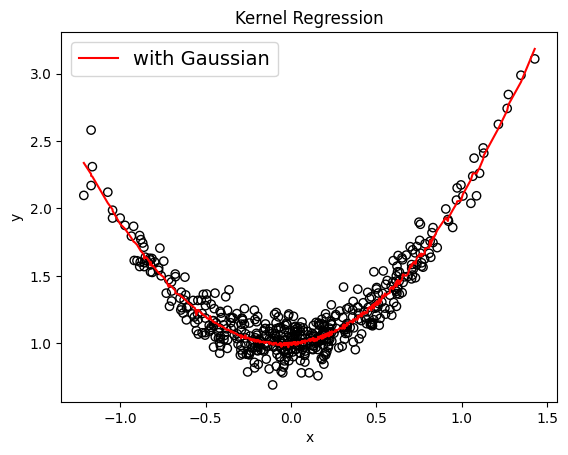

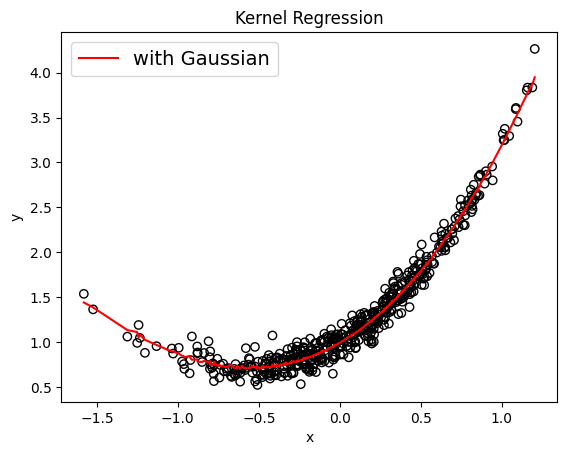

In [6]:
# Plot for x1 and y1
f1_sort = np.array([x for _,x in sorted(zip(x1,func[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort = np.array([x for _,x in sorted(zip(x2,func[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()

### With Random Fourier Features

#### Psi

In [7]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[i])
    return np.array(psi_vector)

def capital_psi(x, w,b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

capital_psi(x_vector[:, 1], w, b, m, dimension)

array([[-0.91901535, -0.        ,  0.05569737,  0.        , -0.54457085,
        -0.        , -1.1512224 , -0.        ,  0.7379604 ,  0.        ,
         0.98794563,  0.        ,  0.09619205,  0.        ,  1.24723403,
         0.        ,  0.88993948,  0.        , -0.4230505 , -0.        ,
        -1.26935308, -0.        ,  1.39358951,  0.        ,  0.21879827,
         0.        ,  1.39326312,  0.        , -0.88845331, -0.        ,
        -1.16381526, -0.        ,  1.25756188,  0.        , -0.534632  ,
        -0.        ,  1.2928116 ,  0.        ,  0.77475126,  0.        ],
       [-0.        , -0.91901535,  0.        ,  0.05569737, -0.        ,
        -0.54457085, -0.        , -1.1512224 ,  0.        ,  0.7379604 ,
         0.        ,  0.98794563,  0.        ,  0.09619205,  0.        ,
         1.24723403,  0.        ,  0.88993948, -0.        , -0.4230505 ,
        -0.        , -1.26935308,  0.        ,  1.39358951,  0.        ,
         0.21879827,  0.        ,  1.39326312, -0.

#### Phi

In [8]:
def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

phi_ = phi(x_vector, w, b, n, m, dimension)
phi_

array([[-0.95440382, -0.        ,  0.06404625, ...,  0.        ,
         0.75225495,  0.        ],
       [-0.        , -0.95440382,  0.        , ...,  1.31954608,
         0.        ,  0.75225495],
       [-0.91901535, -0.        ,  0.05569737, ...,  0.        ,
         0.77475126,  0.        ],
       ...,
       [-0.        , -0.94890533,  0.        , ...,  1.24655531,
         0.        ,  0.75948423],
       [-0.9430152 , -0.        ,  0.39605392, ...,  0.        ,
         0.76605869,  0.        ],
       [-0.        , -0.9430152 ,  0.        , ...,  1.17594321,
         0.        ,  0.76605869]])

#### Alpha

In [12]:
def alpha_approx(phi, y, n, dim, m, lam):
    alpha = np.linalg.inv(phi.T @ phi + lam*np.eye(dim*m)) @ (phi.T@y)
    return alpha

alpha_approximation = alpha_approx(phi_, y, n, dimension, m, lam)
alpha_approximation.shape

(40,)

#### Function Approximation

In [10]:
def function_approximation(alpha, x, n, dim):
    f = np.zeros((dim, n))
    for i in range(n):
        f[:, i] = capital_psi(x[:, i], w, b, m, dim) @ alpha
    return f

# Evt: Gir samme resultat
def func_2(alpha, phi):
    func = phi @ alpha
    return np.array([func[::2], func[1::2]])

function_estimate = function_approximation(alpha_approximation, x_vector, n, dimension)
function_estimate

array([[1.01861744, 1.57619037, 1.40390813, 1.45880345, 0.99677352,
        1.17476915, 2.76595089, 1.02011808, 1.04935011, 1.06947299,
        1.04832904, 1.11044364, 1.06441767, 1.72199087, 1.35814528,
        1.41608839, 1.46750005, 1.02366745, 1.42052171, 1.52364799,
        1.03385045, 1.06336721, 1.27080111, 0.9874179 , 1.0009295 ,
        1.01546784, 1.65731004, 1.43542999, 1.12914477, 1.00413305,
        1.43840236, 1.03666697, 1.12558038, 0.99392374, 1.03606696,
        1.2036282 , 1.03334241, 1.10059462, 1.00004459, 1.75657346,
        1.18827652, 1.63342227, 0.98799619, 1.11161043, 1.05545156,
        1.09690945, 1.10477086, 1.28340844, 1.25971902, 1.40738134,
        1.47527   , 1.37129089, 1.04447694, 1.03579006, 0.98917104,
        1.06971624, 1.50749094, 1.15079035, 1.00740583, 1.2385936 ,
        2.05230908, 1.03810513, 1.13040535, 1.35533308, 1.0322393 ,
        1.00243306, 1.04821263, 2.58852877, 1.12132922, 1.01589715,
        1.08198865, 1.41994411, 1.19199217, 1.92

#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_21928\2328763344.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_21928\2328763344.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


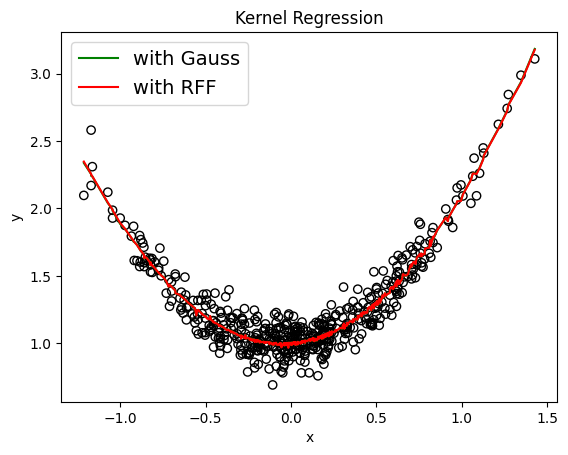

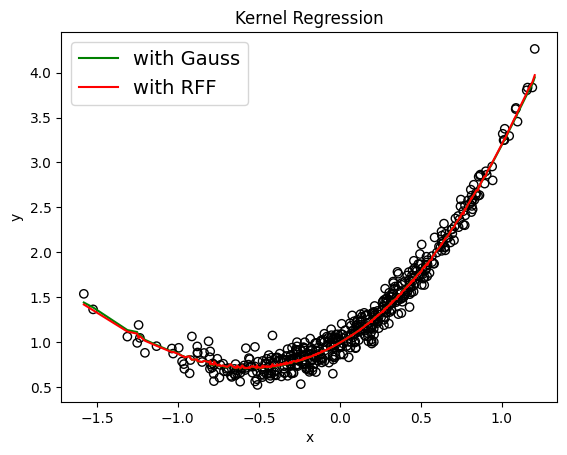

In [11]:
# Plot for x1 and y1
f1_sort_approx = np.array([x for _,x in sorted(zip(x1,function_estimate[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort, c="g", label="with Gauss")
plt.plot(np.sort(x1), f1_sort_approx, c="r", label="with RFF")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort_approx = np.array([x for _,x in sorted(zip(x2,function_estimate[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort, c="g", label="with Gauss")
plt.plot(np.sort(x2), f2_sort_approx, c="r", label="with RFF")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()